In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plots import *
from kls import *
from utils import *
from torch._six import inf
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal as mvn
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
from torch.distributions.gamma import Gamma
from torch import logsumexp
import sys
import time
import datetime

In [2]:
N = 40
K = 3
D = 2

## Model Parameters
NUM_SAMPLES = 10
NUM_HIDDEN = 32
NUM_STATS = K+D*K+D*K
NUM_LATENTS = D * K
NUM_OBS_GLOBAL = D
NUM_OBS_LOCAL = D + K*D + K*D
BATCH_SIZE = 50
NUM_EPOCHS = 10000
LEARNING_RATE = 1e-3
PATH = 'uai-oneshot-all'

In [3]:
Xs = torch.from_numpy(np.load('gmm_dataset_uai/sequences.npy')).float()
# Zs_true = torch.from_numpy(np.load('gmm_dataset2/states.npy')).float()
# mus_true = torch.from_numpy(np.load('gmm_dataset2/means.npy')).float()
# sigma2_true = torch.from_numpy(np.load('gmm_dataset2/covariances.npy')).float()
Pi = torch.from_numpy(np.load('gmm_dataset_uai/init.npy')).float()
num_seqs = Xs.shape[0]

In [4]:
class Encoder_global(nn.Module):
    def __init__(self, num_obs=NUM_OBS_GLOBAL,
                       num_stats=NUM_STATS,
                       num_hidden=NUM_HIDDEN,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()
        self.enc_stats = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_stats))

        self.sigmas_log_alpha = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents))
        self.sigmas_log_beta = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents))
        
        self.mus_mean = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents))
        self.mus_log_nu = nn.Sequential(
            nn.Linear(num_stats, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents))
        
    def forward(self, obs, K, D, num_samples, batch_size):
        stats = self.enc_stats(obs).view(batch_size, N, -1).sum(1)
        q_alpha = torch.exp(self.sigmas_log_alpha(stats)).view(-1, K, D) ## B * K * D
        q_beta = torch.exp(self.sigmas_log_beta(stats)).view(-1, K, D) ## B * K * D
        precisions = Gamma(q_alpha, q_beta).sample((num_samples,)) ## S * B * K * D
        
        q_mean = self.mus_mean(stats).view(-1, K, D).unsqueeze(0).repeat(num_samples, 1, 1, 1)
        q_nu = torch.exp(self.mus_log_nu(stats).view(-1, K, D))
        q_sigma = torch.sqrt(1. / (q_nu.unsqueeze(0).repeat(num_samples, 1, 1, 1) * precisions))
        mus = Normal(q_mean, q_sigma).sample()  
        return q_mean, q_nu, q_alpha, q_beta, q_sigma, mus, precisions ## mus_mean and mus_sigma are S * B * K * D
    
class Encoder_local(nn.Module):
    def __init__(self, num_obs=NUM_OBS_LOCAL,
                       num_hidden=NUM_HIDDEN,
                       num_latents=K):
        super(self.__class__, self).__init__()
        self.enc_onehot = nn.Sequential(
            nn.Linear(num_obs, num_hidden),
            nn.Tanh(),
            nn.Linear(num_hidden, num_latents),
            nn.Softmax(-1))
        
    def forward(self, obs, N, K, D, num_samples, batch_size):
        zs_pi = self.enc_onehot(obs).view(batch_size, N, K)
        zs = cat(zs_pi).sample((num_samples,))
        log_qz = cat(zs_pi).log_prob(zs).view(num_samples, batch_size, -1).sum(-1) ## S * B
        zs = zs.view(num_samples, batch_size, -1, K) ## S * B * N * K
        return zs_pi, zs, log_qz

In [5]:
def initialize():
    enc_global = Encoder_global()
    enc_local = Encoder_local()
#     enc_global.apply(weights_init)

    optimizer =  torch.optim.Adam(list(enc_global.parameters()) + list(enc_local.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))    
    return enc_global, enc_local, optimizer
enc_global, enc_local, optimizer = initialize()

In [6]:
def oneshot(x, Pi, N, K, D, num_samples, batch_size):
    kls_eta_ex = torch.zeros((num_samples, batch_size))
    kls_eta_in = torch.zeros((num_samples, batch_size))
    kls_z_ex = torch.zeros((num_samples, batch_size))
    kls_z_in = torch.zeros((num_samples, batch_size))
    ##
    log_weights = torch.zeros((num_samples, batch_size))

    for l in range(num_samples):
        q_mean, q_nu, q_alpha, q_beta, q_sigma, mus, precisions, log_q_eta = M_step(enc_global, x, N, D, K, batch_size)
        zs_pi, z, log_q_z = E_step(enc_local, x, mus, precisions, N, D, K, batch_size)
        log_p_joint = log_joints_gmm(x, z, Pi, mus, precisions, N, D, K, prior_mean, prior_nu, prior_alpha, prior_beta, batch_size)
        log_weights[l] = log_p_joint - log_q_z - log_q_eta
        ## kl of global
        p_mean, p_nu, p_alpha, p_beta = post_global(x, z, prior_mean, prior_nu, prior_alpha, prior_beta, N, K, D, batch_size)
        kl_eta_ex, kl_eta_in = kls_NGs(p_mean, p_nu, p_alpha, p_beta, q_mean, q_nu, q_alpha, q_beta)
        kls_eta_ex[l] = kl_eta_ex
        kls_eta_in[l] = kl_eta_in
        ## kl of local
        p_logits = post_local(x, Pi, mus, precisions, N, K, D, batch_size)
        kl_z_ex, kl_z_in = kls_cats(p_logits, torch.log(zs_pi))
        kls_z_ex[l] = kl_z_ex
        kls_z_in[l] = kl_z_in   

    weights = torch.exp(log_weights - logsumexp(log_weights, 0)).detach()
    ess = (1./ (weights ** 2).sum(0)).mean()
    ## EUBO and ELBO
    eubo = torch.mul(weights, log_weights).sum(0).mean()
    elbo = log_weights.mean(0).mean()
    ## weighted average KLs for local and global posterior
    KL_eta_ex = torch.mul(weights, kls_eta_ex).sum(0).mean()
    KL_eta_in = torch.mul(weights, kls_eta_in).sum(0).mean()
    KL_z_ex = torch.mul(weights, kls_z_ex).sum(0).mean()
    KL_z_in = torch.mul(weights, kls_z_in).sum(0).mean()     
    return eubo, elbo, ess, KL_eta_ex, KL_eta_in, KL_z_ex, KL_z_in

In [7]:
EUBOs = []
ELBOs = []
ESSs = []
KLs_eta_ex = []
KLs_eta_in = []
KLs_z_ex = []
KLs_z_in = []

# EUBOs_gs = []
# ELBOs_gs = []
# ESSs_gs = []
# KLs_eta_ex_gs = []
# KLs_eta_in_gs = []
# KLs_z_ex_gs = []
# KLs_z_in_gs = []

flog = open('results/log-' + PATH + '.txt', 'w+')
flog.write('EUBO, ELBO, ESS, KLs_eta_ex, KLs_eta_in, KL_z_ex, KL_z_in\n')
flog.close()
prior_mean, prior_nu, prior_alpha, prior_beta = init_priors(K, D, BATCH_SIZE)
time_start = time.time()

num_batches = int((Xs.shape[0] / BATCH_SIZE))
for epoch in range(NUM_EPOCHS):
    indices = torch.randperm(num_seqs)
    EUBO = 0.0EUBOs = []
ELBOs = []
ESSs = []
KLs_eta_ex = []
KLs_eta_in = []
KLs_z_ex = []
KLs_z_in = []

# EUBOs_gs = []
# ELBOs_gs = []
# ESSs_gs = []
# KLs_eta_ex_gs = []
# KLs_eta_in_gs = []
# KLs_z_ex_gs = []
# KLs_z_in_gs = []

flog = open('results/log-' + PATH + '.txt', 'w+')
flog.write('EUBO, ELBO, ESS, KLs_eta_ex, KLs_eta_in, KL_z_ex, KL_z_in\n')
flog.close()
prior_mean, prior_nu, prior_alpha, prior_beta = init_priors(K, D, BATCH_SIZE)
time_start = time.time()

num_batches = int((Xs.shape[0] / BATCH_SIZE))
for epoch in range(NUM_EPOCHS):
    indices = torch.randperm(num_seqs)
    EUBO = 0.0
    ELBO = 0.0
    ESS = 0.0
    KL_eta_ex = 0.0
    KL_eta_in = 0.0
    KL_z_ex = 0.0
    KL_z_in = 0.0

    for step in range(num_batches):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        batch_Xs = Xs[batch_indices]
        batch_Xs = shuffler(batch_Xs, N, K, D, BATCH_SIZE)
        eubo, elbo, ess, kl_eta_ex, kl_eta_in, kl_z_ex, kl_z_in = oneshot(batch_Xs, Pi, N, K, D, NUM_SAMPLES, BATCH_SIZE)
        eubo.backward()
        optimizer.step()
        EUBO += eubo.item()
        ELBO += elbo.item()
        ESS += ess.item()
        KL_eta_ex += kl_eta_ex.item()
        KL_eta_in += kl_eta_in.item()
        KL_z_ex += kl_z_ex.item()
        KL_z_in += kl_z_in.item()
        ##
#         EUBOs_gs.append(eubo.item())
#         ELBOs_gs.append(elbo.item())
#         ESSs_gs.append(ess.item())
#         ##
#         KLs_eta_ex_gs.append(kl_eta_ex.item())
#         KLs_eta_in_gs.append(kl_eta_in.item())
#         KLs_z_ex_gs.append(kl_z_ex.item())
#         KLs_z_in_gs.append(kl_z_in.item())
        
    EUBO /= num_batches
    ELBO /= num_batches
    ESS /= num_batches
    KL_eta_ex /= num_batches
    KL_eta_in /= num_batches
    KL_z_ex /= num_batches
    KL_z_in /= num_batches

    EUBOs.append(EUBO)
    ELBOs.append(ELBO)
    ESSs.append(ESS)
    ##
    KLs_eta_ex.append(KL_eta_ex)
    KLs_eta_in.append(KL_eta_in)
    KLs_z_ex.append(KL_z_ex)
    KLs_z_in.append(KL_z_in)

    
    flog = open('results/log-' + PATH + '.txt', 'a+')
    flog.write(str(EUBO) + ', ' + str(ELBO) + ', ' + str(ESS) + ', ' + str(KL_eta_ex) + ', ' + str(KL_eta_in) + ', ' + str(KL_z_ex) + ', ' + str(KL_z_in) + '\n')
    flog.close()
    
    if epoch%10 == 0:
        time_end = time.time()
        print('epoch=%d, EUBO=%.3f, ELBO=%.3f, ESS=%.3f, EX_eta=%.3f, IN_eta=%.3f, EX_z=%.3f, IN_z=%.3f (%ds)'
                  % (epoch, EUBO, ELBO, ESS,  KL_eta_ex, KL_eta_in, KL_z_ex, KL_z_in, time_end - time_start))
        time_start = time.time()
    ELBO = 0.0
    ESS = 0.0
    KL_eta_ex = 0.0
    KL_eta_in = 0.0
    KL_z_ex = 0.0
    KL_z_in = 0.0

    for step in range(num_batches):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        batch_Xs = Xs[batch_indices]
        batch_Xs = shuffler(batch_Xs, N, K, D, BATCH_SIZE)
        eubo, elbo, ess, kl_eta_ex, kl_eta_in, kl_z_ex, kl_z_in = oneshot(batch_Xs, Pi, N, K, D, NUM_SAMPLES, BATCH_SIZE)
        eubo.backward()
        optimizer.step()
        EUBO += eubo.item()
        ELBO += elbo.item()
        ESS += ess.item()
        KL_eta_ex += kl_eta_ex.item()
        KL_eta_in += kl_eta_in.item()
        KL_z_ex += kl_z_ex.item()
        KL_z_in += kl_z_in.item()
        ##
#         EUBOs_gs.append(eubo.item())
#         ELBOs_gs.append(elbo.item())
#         ESSs_gs.append(ess.item())
#         ##
#         KLs_eta_ex_gs.append(kl_eta_ex.item())
#         KLs_eta_in_gs.append(kl_eta_in.item())
#         KLs_z_ex_gs.append(kl_z_ex.item())
#         KLs_z_in_gs.append(kl_z_in.item())
        
    EUBO /= num_batches
    ELBO /= num_batches
    ESS /= num_batches
    KL_eta_ex /= num_batches
    KL_eta_in /= num_batches
    KL_z_ex /= num_batches
    KL_z_in /= num_batches

    EUBOs.append(EUBO)
    ELBOs.append(ELBO)
    ESSs.append(ESS)
    ##
    KLs_eta_ex.append(KL_eta_ex)
    KLs_eta_in.append(KL_eta_in)
    KLs_z_ex.append(KL_z_ex)
    KLs_z_in.append(KL_z_in)

    
    flog = open('results/log-' + PATH + '.txt', 'a+')
    flog.write(str(EUBO) + ', ' + str(ELBO) + ', ' + str(ESS) + ', ' + str(KL_eta_ex) + ', ' + str(KL_eta_in) + ', ' + str(KL_z_ex) + ', ' + str(KL_z_in) + '\n')
    flog.close()
    
    if epoch%10 == 0:
        time_end = time.time()
        print('epoch=%d, EUBO=%.3f, ELBO=%.3f, ESS=%.3f, EX_eta=%.3f, IN_eta=%.3f, EX_z=%.3f, IN_z=%.3f (%ds)'
                  % (epoch, EUBO, ELBO, ESS,  KL_eta_ex, KL_eta_in, KL_z_ex, KL_z_in, time_end - time_start))
        time_start = time.time()

epoch=0, EUBO=-305.207, ELBO=-456.821, ESS=1.087, EX_eta=229.371, IN_eta=17.558, EX_z=60.041, IN_z=16.045 (6s)
epoch=10, EUBO=-212.925, ELBO=-234.261, ESS=1.333, EX_eta=40.706, IN_eta=30.940, EX_z=4.756, IN_z=4.061 (62s)
epoch=20, EUBO=-204.400, ELBO=-222.809, ESS=1.363, EX_eta=34.319, IN_eta=23.551, EX_z=3.616, IN_z=3.018 (66s)
epoch=30, EUBO=-200.723, ELBO=-218.406, ESS=1.385, EX_eta=34.028, IN_eta=21.676, EX_z=2.918, IN_z=2.396 (65s)
epoch=40, EUBO=-198.359, ELBO=-215.565, ESS=1.397, EX_eta=34.952, IN_eta=20.373, EX_z=2.550, IN_z=2.059 (63s)
epoch=50, EUBO=-196.912, ELBO=-214.037, ESS=1.404, EX_eta=34.881, IN_eta=19.251, EX_z=2.340, IN_z=1.901 (64s)
epoch=60, EUBO=-195.390, ELBO=-212.044, ESS=1.417, EX_eta=34.521, IN_eta=18.284, EX_z=2.093, IN_z=1.682 (65s)
epoch=70, EUBO=-194.484, ELBO=-211.667, ESS=1.406, EX_eta=34.664, IN_eta=16.815, EX_z=2.076, IN_z=1.541 (64s)
epoch=80, EUBO=-193.838, ELBO=-210.546, ESS=1.411, EX_eta=34.227, IN_eta=16.622, EX_z=2.010, IN_z=1.474 (62s)
epoch=90,

KeyboardInterrupt: 

In [8]:
torch.save(enc_global.state_dict(), 'models/global-enc-' + PATH)
torch.save(enc_local.state_dict(), 'models/local-enc' + PATH)

In [9]:
save_results(EUBOs, ELBOs, ESSs, KLs_eta_ex, KLs_eta_in, KLs_z_ex, KLs_z_in, PATH, 'Epoch')

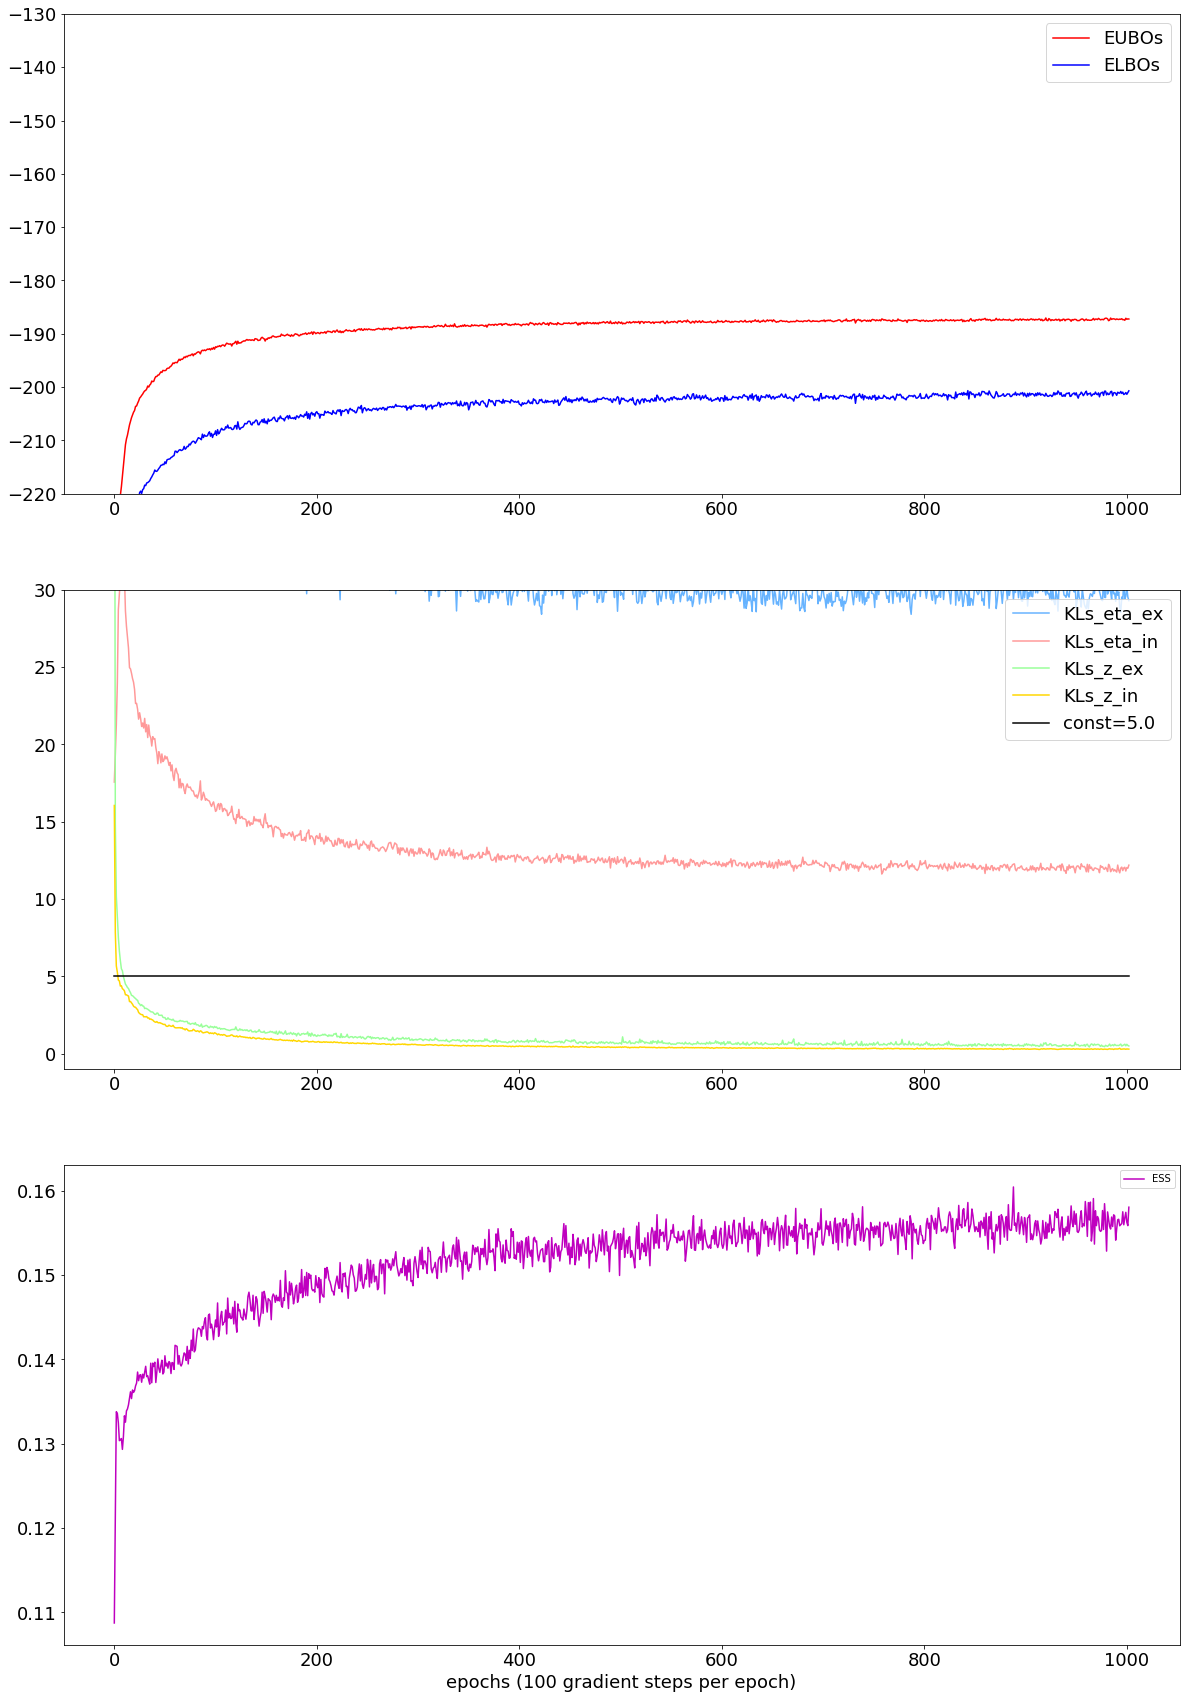

In [10]:
plot_results(EUBOs, ELBOs, ESSs, KLs_eta_ex, KLs_eta_in, KLs_z_ex, KLs_z_in, NUM_SAMPLES, num_batches, PATH)

In [11]:
def sample_single_batch(num_seqs, N, K, D, batch_size):
    indices = torch.randperm(num_seqs)
    batch_indices = indices[0*batch_size : (0+1)*batch_size]
    batch_Xs = Xs[batch_indices]
    batch_Xs = shuffler(batch_Xs, N, K, D, batch_size)
    return batch_Xs

def test(x, num_seqs, Pi, N, K, D, batch_size):
    q_mean, q_nu, q_alpha, q_beta, q_sigma, mus, precisions, log_q_eta = M_step(enc_global, x, N, D, K, batch_size)
    zs_pi, z, log_q_z = E_step(enc_local, x, mus, precisions, N, D, K, batch_size)
    E_precisions = q_alpha / q_beta
    E_mus = q_mean
    E_z = torch.argmax(zs_pi, dim=-1)

    return E_mus, E_precisions, E_z

x = sample_single_batch(num_seqs, N, K, D, BATCH_SIZE)
E_mus, E_precisions, E_z = test(x, num_seqs, Pi, N, K, D, BATCH_SIZE)

In [12]:
def plot_final_samples(Xs, Zs, mus, precisions, batch_size, PATH):
    colors = ['r', 'b', 'gold']
    fig = plt.figure(figsize=(25,50))
    for b in range(batch_size):
        ax = fig.add_subplot(int(batch_size / 5), 5, b+1)
        x = Xs[b].data.numpy()
        z = Zs[b].data.numpy()
        mu = mus[b].data.numpy()
        precision = precisions[b].data.numpy()

        covs = np.zeros((K, D, D))
        assignments = z
        for k in range(K):
            covs[k] = np.diag(1. / precision[k])
            xk = x[np.where(assignments == k)]
            ax.scatter(xk[:, 0], xk[:, 1], c=colors[k])
            plot_cov_ellipse(cov=covs[k], pos=mu[k], nstd=2, ax=ax, alpha=0.2, color=colors[k])
        ax.set_ylim([-10, 10])
        ax.set_xlim([-10, 10])
    plt.savefig('results/modes' + PATH + '.svg')

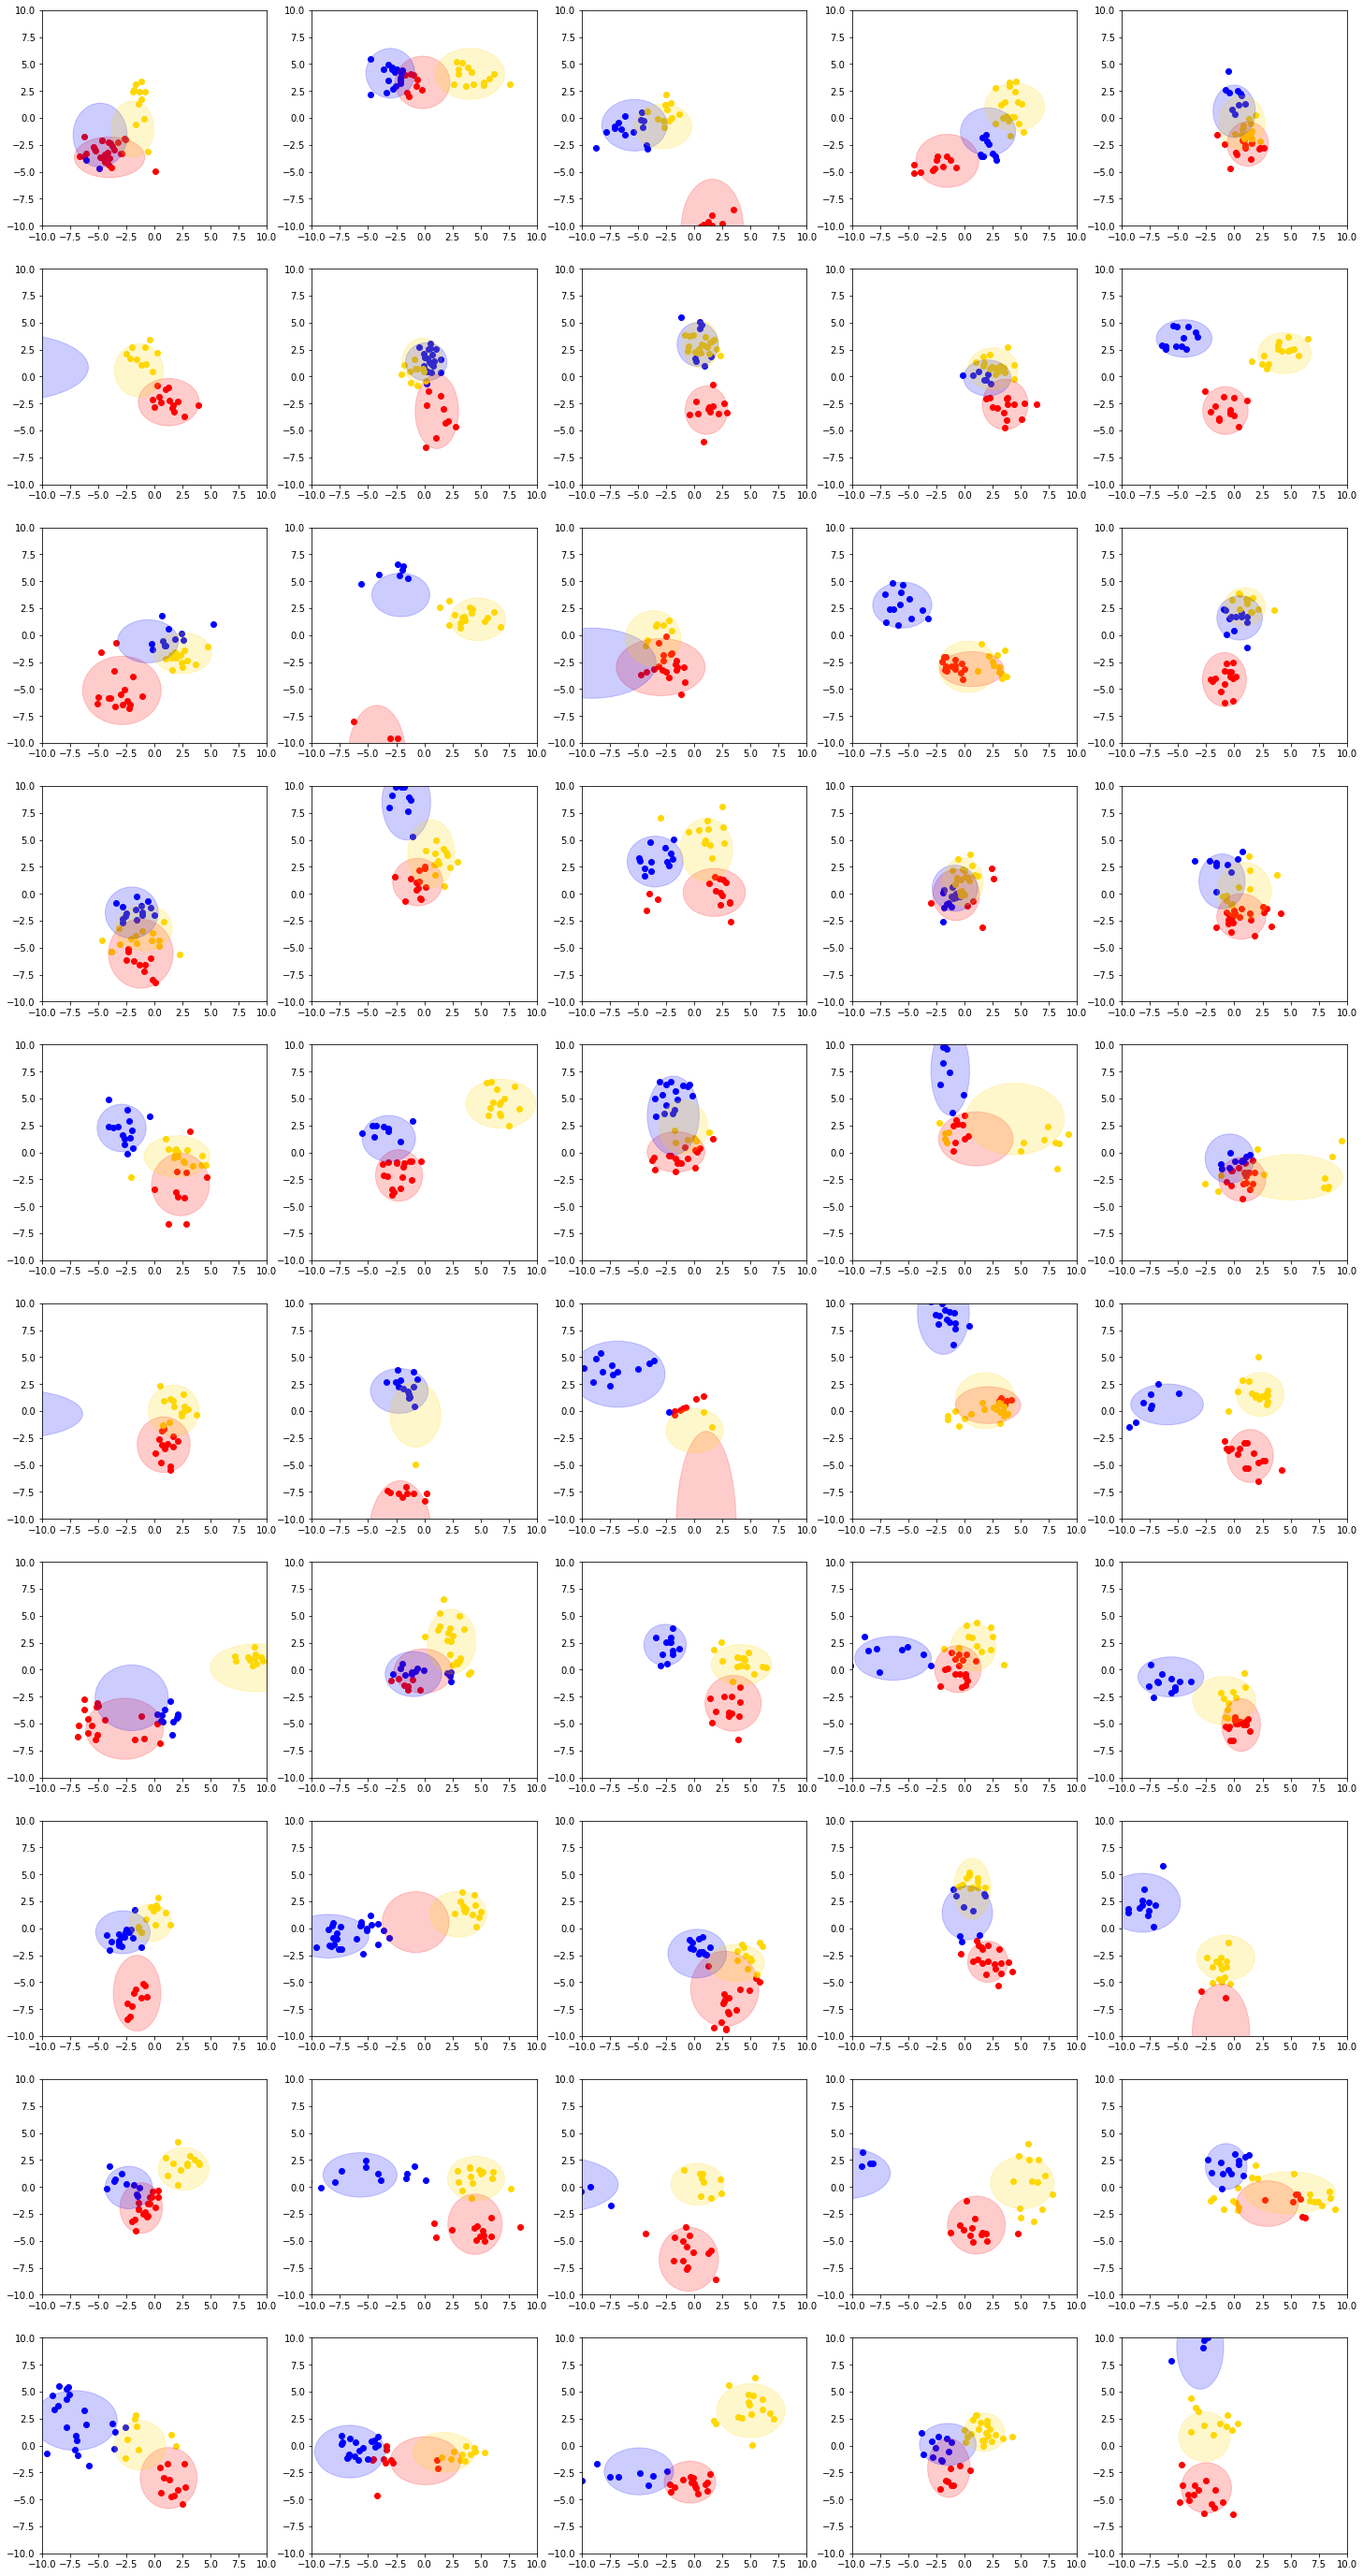

In [13]:
plot_final_samples(x, E_z, E_mus, E_precisions, BATCH_SIZE, PATH)

In [ ]:
plt.plot(LLs[:20])

In [ ]:
plt.plot(LLs)

In [ ]:
plt.plot(LLs[:10])

In [ ]:
np.array(LLs).mean()

In [ ]:
LLs[20]